In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 读取Excel文件中的所有sheet数据
def read_excel_sheets(file_path):
    excel_data = pd.ExcelFile(file_path)
    df_list = []
    for sheet_name in excel_data.sheet_names:
        df_list.append(excel_data.parse(sheet_name))
    return pd.concat(df_list, ignore_index=True)


In [11]:
# 假设你的Excel文件名为'data.xlsx'
data = read_excel_sheets('bio_train_trans.xlsx')

In [12]:
data['下一酸钠'] = data['酸钠'].shift(-1)
data['下一残糖'] = data['残糖g/dl'].shift(-1)


In [13]:
data.head(10)

,发酵周期/h,酶活,酸钠,残糖g/dl,菌浓ml/50ml,菌浓g/50ml,PH值,罐压,风量L/h,转速r/min,溶氧,温度,碱重kg,重量KG,下一酸钠,下一残糖
0,0.00,11.10000,0.65,34.00,2.0,0.0143,5.22,0.071,1500,550,99.1,38.0,13.41,33.2,2.36,32.00
1,4.00,42.20000,2.36,32.00,8.0,0.0206,5.21,0.069,1500,550,91.7,38.0,13.26,31.2,5.42,28.50
2,8.00,120.00000,5.42,28.50,15.0,0.0270,5.18,0.070,1500,550,54.5,38.0,12.82,31.1,9.31,23.75
3,12.00,225.00000,9.31,23.75,17.0,0.0249,5.18,0.070,1500,550,35.9,38.0,12.15,31.7,13.29,19.20
4,16.00,314.42432,13.29,19.20,18.0,0.0241,5.18,0.070,1500,550,27.5,38.0,11.49,31.9,17.56,14.90
5,20.00,327.75680,17.56,14.90,20.0,0.0247,5.18,0.070,1500,550,20.8,38.0,10.75,32.4,22.11,12.00
6,24.00,337.80000,22.11,12.00,22.0,0.0340,5.18,0.069,1500,550,17.0,38.0,10.03,32.9,25.40,6.80
7,28.00,516.60000,25.40,6.80,22.0,0.0350,5.17,0.069,1500,550,14.6,38.0,9.34,33.2,29.26,1.82
8,32.55,677.70000,29.26,1.82,33.0,0.0468,5.18,0.071,1500,550,84.5,37.9,8.55,33.7,1.82,34.50
9,0.00,41.10000,1.82,34.50,10.0,0.0112,5.30,0.086,1500,550,77.7,38.0,8.51,31.7,4.71,31.75


In [14]:
zero_indices = data[data['发酵周期/h'] == 0].index

# 删除这些行的前一行数据
# 要确保我们不删除超出DataFrame索引范围的行，需要检查索引是否大于0
rows_to_delete = zero_indices[zero_indices > 0] - 1

data = data.drop(rows_to_delete)

In [15]:
data.head(10)

,发酵周期/h,酶活,酸钠,残糖g/dl,菌浓ml/50ml,菌浓g/50ml,PH值,罐压,风量L/h,转速r/min,溶氧,温度,碱重kg,重量KG,下一酸钠,下一残糖
0,0.0,11.10000,0.65,34.00,2.0,0.0143,5.22,0.071,1500,550,99.1,38.0,13.41,33.2,2.36,32.00
1,4.0,42.20000,2.36,32.00,8.0,0.0206,5.21,0.069,1500,550,91.7,38.0,13.26,31.2,5.42,28.50
2,8.0,120.00000,5.42,28.50,15.0,0.0270,5.18,0.070,1500,550,54.5,38.0,12.82,31.1,9.31,23.75
3,12.0,225.00000,9.31,23.75,17.0,0.0249,5.18,0.070,1500,550,35.9,38.0,12.15,31.7,13.29,19.20
4,16.0,314.42432,13.29,19.20,18.0,0.0241,5.18,0.070,1500,550,27.5,38.0,11.49,31.9,17.56,14.90
5,20.0,327.75680,17.56,14.90,20.0,0.0247,5.18,0.070,1500,550,20.8,38.0,10.75,32.4,22.11,12.00
6,24.0,337.80000,22.11,12.00,22.0,0.0340,5.18,0.069,1500,550,17.0,38.0,10.03,32.9,25.40,6.80
7,28.0,516.60000,25.40,6.80,22.0,0.0350,5.17,0.069,1500,550,14.6,38.0,9.34,33.2,29.26,1.82
9,0.0,41.10000,1.82,34.50,10.0,0.0112,5.30,0.086,1500,550,77.7,38.0,8.51,31.7,4.71,31.75
10,4.0,36.60000,4.71,31.75,7.0,0.0155,5.17,0.070,1500,550,97.0,38.0,8.19,31.7,9.41,26.75


In [16]:
data = data.dropna()
# 将数据分为特征和目标变量
features = ['酶活', '菌浓ml/50ml','酸钠','残糖g/dl', '菌浓g/50ml', 'PH值', '罐压', '风量L/h', '转速r/min', '溶氧', '温度', '碱重kg', '重量KG']
target_acid_sodium = '下一酸钠'
target_sugar = '下一残糖'

# 分割数据集
X = data[features]
y_acid_sodium = data[target_acid_sodium]
y_sugar = data[target_sugar]

X_train, X_test, y_acid_sodium_train, y_acid_sodium_test, y_sugar_train, y_sugar_test = train_test_split(X, y_acid_sodium, y_sugar, test_size=0.2)

In [17]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_acid_sodium_train=y_acid_sodium_train.to_numpy()
y_acid_sodium_test=y_acid_sodium_test.to_numpy()
y_sugar_train=y_sugar_train.to_numpy()
y_sugar_test=y_sugar_test.to_numpy()

In [18]:
# 归一化
from sklearn.preprocessing import MinMaxScaler

# 初始化标准化器
scaler_X = MinMaxScaler()
scaler_y_acid_sodium = MinMaxScaler()
scaler_y_sugar = MinMaxScaler()

# 对训练集进行拟合和变换
X_train = scaler_X.fit_transform(X_train)
y_acid_sodium_train = scaler_y_acid_sodium.fit_transform(y_acid_sodium_train.reshape(-1, 1)).reshape(-1)
y_sugar_train = scaler_y_sugar.fit_transform(y_sugar_train.reshape(-1, 1)).reshape(-1)

# 对测试集仅进行变换
X_test = scaler_X.transform(X_test)
y_acid_sodium_test = scaler_y_acid_sodium.transform(y_acid_sodium_test.reshape(-1, 1)).reshape(-1)
y_sugar_test = scaler_y_sugar.transform(y_sugar_test.reshape(-1, 1)).reshape(-1)


In [32]:
from sklearn.decomposition import PCA
pca = PCA(1)  
X_pca = pca.fit_transform(scaler_X.fit_transform(X.to_numpy()))  
a=[] 
# 查看每个主成分的方差解释率  
print("Explained variance ratio:", pca.explained_variance_ratio_)  
  
# 查看主成分载荷（特征向量）  
print("Components (feature weights):")  
for i, component in enumerate(pca.components_):  
    print(f"Principal Component {i+1}: {component}")  
  
# 如果要计算每个特征在各个主成分上的绝对权重（一种贡献率的度量）  
feature_weights = np.abs(pca.components_)  
  
# 打印每个特征在每个主成分上的权重  
for i, weights in enumerate(feature_weights.T):  # 转置以按特征显示  
    print(f"Feature {i+1} weights across PCs: {weights}")
    print(weights/sum(feature_weights.T))
    a.append(float(weights/sum(feature_weights.T)))

Explained variance ratio: [0.41591727]
Components (feature weights):
Principal Component 1: [-0.29380823 -0.25421201 -0.48440228  0.56172527  0.00398121  0.01436772
 -0.01570865 -0.27680781 -0.23615041  0.15582671  0.10863536  0.2431286
 -0.26611724]
Feature 1 weights across PCs: [0.29380823]
[0.10079629]
Feature 2 weights across PCs: [0.25421201]
[0.08721208]
Feature 3 weights across PCs: [0.48440228]
[0.16618306]
Feature 4 weights across PCs: [0.56172527]
[0.19271013]
Feature 5 weights across PCs: [0.00398121]
[0.00136583]
Feature 6 weights across PCs: [0.01436772]
[0.00492911]
Feature 7 weights across PCs: [0.01570865]
[0.00538914]
Feature 8 weights across PCs: [0.27680781]
[0.09496398]
Feature 9 weights across PCs: [0.23615041]
[0.08101572]
Feature 10 weights across PCs: [0.15582671]
[0.0534592]
Feature 11 weights across PCs: [0.10863536]
[0.03726935]
Feature 12 weights across PCs: [0.2431286]
[0.08340971]
Feature 13 weights across PCs: [0.26611724]
[0.09129639]


[0.10079629026291216,
 0.0872120809190474,
 0.16618306467795702,
 0.19271013334568743,
 0.0013658279871114434,
 0.004929109019874576,
 0.005389139032592526,
 0.09496398236993484,
 0.08101571831955774,
 0.053459204268458446,
 0.037269346964931525,
 0.08340971338479602,
 0.09129638944713891]

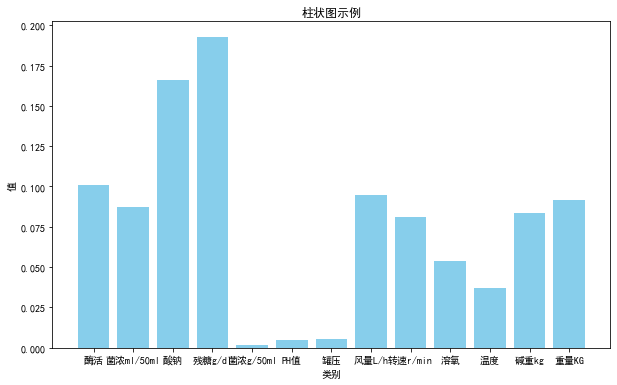

In [33]:
import matplotlib.pyplot as plt  

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体  
plt.figure(figsize=(10, 6))
# 接下来是你的绘图代码  
plt.bar(features,a , color='skyblue')  
plt.xlabel('类别')  
plt.ylabel('值')  
plt.title('柱状图示例')  
plt.show()

In [41]:
# 训练模型
from sklearn.model_selection import cross_val_score 
svr_acid_sodium = SVR()
svr_sugar = SVR()

score_acid = cross_val_score(svr_acid_sodium, scaler_X.fit_transform(X.to_numpy()), scaler_y_acid_sodium.fit_transform(y_acid_sodium.to_numpy().reshape(-1, 1)).reshape(-1), cv=5, scoring='neg_mean_squared_error')  
score_sugar = cross_val_score(svr_sugar, scaler_X.fit_transform(X.to_numpy()),scaler_y_acid_sodium.fit_transform(y_sugar.to_numpy().reshape(-1, 1)).reshape(-1), cv=5, scoring='neg_mean_squared_error')  

In [43]:
mse_scores = -score_acid 
# 打印每折的MSE  

print("酸钠每折的MSE:", mse_scores)  

# 计算平均MSE  

print("酸钠平均MSE:", mse_scores.mean())

酸钠每折的MSE: [0.01755068 0.00391073 0.00392847 0.02164251 0.01696242]
酸钠平均MSE: 0.01279896190145631


In [44]:
mse_scores = -score_sugar
# 打印每折的MSE  

print("残糖每折的MSE:", mse_scores)  

# 计算平均MSE  

print("残糖平均MSE:", mse_scores.mean())

残糖每折的MSE: [0.00731966 0.00348851 0.00526917 0.01260801 0.0245139 ]
残糖平均MSE: 0.010639850257285416


In [45]:
#使用六维特征作为数据输入
features6 = ['酶活', '菌浓ml/50ml','酸钠','残糖g/dl', '风量L/h', '重量KG']
svr_acid_sodium = SVR()
svr_sugar = SVR()

score_acid = cross_val_score(svr_acid_sodium, scaler_X.fit_transform(data[features6].to_numpy()), scaler_y_acid_sodium.fit_transform(y_acid_sodium.to_numpy().reshape(-1, 1)).reshape(-1), cv=5, scoring='neg_mean_squared_error')  
score_sugar = cross_val_score(svr_sugar, scaler_X.fit_transform(data[features6].to_numpy()),scaler_y_acid_sodium.fit_transform(y_sugar.to_numpy().reshape(-1, 1)).reshape(-1), cv=5, scoring='neg_mean_squared_error')  

In [46]:
mse_scores = -score_acid 
# 打印每折的MSE  

print("酸钠每折的MSE:", mse_scores)  

# 计算平均MSE  

print("酸钠平均MSE:", mse_scores.mean())

酸钠每折的MSE: [0.01521258 0.00267368 0.00338437 0.01699292 0.00717239]
酸钠平均MSE: 0.009087187957178215


In [47]:
mse_scores = -score_sugar
# 打印每折的MSE  

print("残糖每折的MSE:", mse_scores)  

# 计算平均MSE  

print("残糖平均MSE:", mse_scores.mean())

残糖每折的MSE: [0.00766713 0.00310499 0.00654307 0.00941884 0.01088605]
残糖平均MSE: 0.007524018091326047
